# `DAG`
- circuit in quafu to dag
- dag visualization briefly
- dag to circuit in quafu

In [42]:
import numpy as np
from quafu import User,QuantumCircuit,Task ,simulate
import quafu
import networkx as nx
from typing import Dict, Any, List

you should install `pygraphviz` ,`pydot` package  for visualization  
`pip install pygraphviz `    
`pip install pydot`


In [43]:
import pygraphviz as pgv
from networkx.drawing.nx_pydot import write_dot

In [44]:
# user = User()
# # user.save_apitoken("<your API token>")

In [45]:
# task = Task()
# task.config(backend="ScQ-P18", shots=2000, compile=True)

In [46]:
# 0.1.0 Wrapping Gates to Make them hashable in a graph structure and give them a unique identifying label
import dataclasses
@dataclasses.dataclass
class GateWrapper: 
    name:Any            # gate.name
    pos:List[Any]       # gate.pos
    paras:List[Any]        # gate.paras
    # matrix:List[Any]   # for gate in [QuantumGate] 
    duration:int       # for gate in [Delay,XYResonance] in quafu
    unit:str           # for gate in [Delay,XYResonance] in quafu
    label:str
        
    def __hash__(self):
        return hash((type(self.name), tuple(self.pos) ,self.label))
    
    def __str__(self):
        args = ','.join(str(q) for q in self.pos)
        if self.paras == None:
            return f'{self.label}{{{self.name}({args})}}'
        else:
            # if self.paras not a list, then make it a list  of str of .3f float
            if not isinstance(self.paras, list):
                formatted_paras = [f'{self.paras:.3f}']
            else:
                formatted_paras = [f'{p:.3f}' for p in self.paras]  
                
            formatted_paras_str = ','.join(formatted_paras)
            
            return f'{self.label}{{{self.name}({args})}}({formatted_paras_str})'
    
    def __repr__(self): 
        return str(self)


# 0.1.1 Building a Dependency Graph using NetworkX
def build_program_dependency_graph(circuit):
    '''
    Builds a program dependency graph like in the video. Feel free to modify this or build your own as you see fit.
    Here we convert the gates into their hashable versions and add a label.
    '''
    
    # Starting Label Index
    i = 0
    
    # A dictionary to store the last use of any qubit
    qubit_last_use = {}
    
    g = nx.MultiDiGraph()  # two nodes can have multiple edges
    # g = nx.DiGraph()   # two nodes can only have one edge
    
    # Add the start node 
    # g.add_node(-1,{"color": "green"})
    g.add_nodes_from([(-1, {"color": "green"})])
    
    for gate in circuit.gates:
        
        if type(gate.pos) != list: # if gate.pos is not a list, make it a list
            gate.pos = [gate.pos]

        
        # use getattr check 'paras' and other attributes if exist. if the attr doesn't exist,return None
        paras = getattr(gate, 'paras', None)
        # matrix = getattr(gate, 'matrix', None)
        duration = getattr(gate, 'duration', None)
        unit = getattr(gate, 'unit', None)
        if paras is None:
            gate.paras = None 
        elif type(gate.paras) != list: # if paras is not a list, make it a list
            gate.paras = [gate.paras]    
        # if matrix is None:
        #     gate.matrix = None
        if duration is None:
            gate.duration = None
        if unit is None:
            gate.unit = None
        
        # hashable_gate = GateWrapper(gate.name, gate.pos, gate.paras,gate.matrix,gate.duration,gate.unit, label=i)
        hashable_gate = GateWrapper(gate.name, gate.pos, gate.paras,gate.duration,gate.unit, label=i)
        i += 1
        
        g.add_node(hashable_gate,color="blue")
        
        # Add edges based on qubit_last_use; update last use
        for qubit in hashable_gate.pos:
            if qubit in qubit_last_use:
                g.add_edge(qubit_last_use[qubit], hashable_gate,label=f'q{qubit}')
            else:
                g.add_edge(-1, hashable_gate,label=f'q{qubit}',color="green")
            
            qubit_last_use[qubit] = hashable_gate
            
    # Add the end node
    # g.add_node(float('inf'),{"color": "red"})
    g.add_nodes_from([(float('inf'), {"color": "red"})])
    
    for qubit in qubit_last_use:
        g.add_edge(qubit_last_use[qubit], float('inf'),label=f'q{qubit}',color="red")
    
    return g
    
# 0.1.2 transform gate in dag nodes  to gate in circuit which can be added to circuit
def gate_transform(gate_in_dag, circuit):
    """
    transform gate in dag graph, to gate in circuit which can be added to circuit

    Args:
        gate_in_dag: gate in dag graph
        circuit: circuit to be added to

    Returns:
        gate in circuit: gate in circuit which can be added to circuit
    
    """
    gate = gate_in_dag
    
    # gate.name lowercase
    gate.name = gate.name.lower()
    
    # single qubit gate
    if gate.name == "x":
        circuit.x(gate.pos[0])   # gate.pos is a list,transformed in build_program_dependency_graph()
    elif gate.name == "y":
        circuit.y(gate.pos[0])
    elif gate.name == "z":
        circuit.z(gate.pos[0])
    elif gate.name == "h":
        circuit.h(gate.pos[0])
    elif gate.name == "s":
        circuit.s(gate.pos[0])
    elif gate.name == "sdg":
        circuit.sdg(gate.pos[0])
    elif gate.name == "t":
        circuit.t(gate.pos[0])
    elif gate.name == "tdg":
        circuit.tdg(gate.pos[0])
    elif gate.name == "rx":
        circuit.rx(gate.pos[0], gate.paras[0]) # gate.paras is a list,transformed in build_program_dependency_graph()
    elif gate.name == "ry":
        circuit.ry(gate.pos[0], gate.paras[0])
    elif gate.name == "rz":
        circuit.rz(gate.pos[0], gate.paras[0])
    elif gate.name == "id":
        circuit.id(gate.pos[0])
    elif gate.name == "sx":
        circuit.sx(gate.pos[0])
    elif gate.name == "sy":
        circuit.sy(gate.pos[0])
    elif gate.name == "w":
        circuit.w(gate.pos[0])
    elif gate.name == "sw":
        circuit.sw(gate.pos[0])
    elif gate.name == "p":
        circuit.p(gate.pos[0], gate.paras[0])    
    
    # two qubit gate        
    elif gate.name == "cp":
        circuit.cp(gate.pos[0], gate.pos[1], gate.paras[0])
    elif gate.name == "swap":
        circuit.swap(gate.pos[0], gate.pos[1])
    elif gate.name == "rxx":
        circuit.rxx(gate.pos[0], gate.pos[1], gate.paras[0])
    elif gate.name == "ryy":
        circuit.ryy(gate.pos[0], gate.pos[1], gate.paras[0])
    elif gate.name == "rzz":
        circuit.rzz(gate.pos[0], gate.pos[1], gate.paras[0])
    elif gate.name == "cx":
        circuit.cnot(gate.pos[0], gate.pos[1])
    elif gate.name == "cy":
        circuit.cy(gate.pos[0], gate.pos[1])
    elif gate.name == "cz":
        circuit.cz(gate.pos[0], gate.pos[1])
    elif gate.name == "cs":
        circuit.cs(gate.pos[0], gate.pos[1])
    elif gate.name == "ct":
        circuit.ct(gate.pos[0], gate.pos[1])
    
    # three qubit gate    
    elif gate.name == "ccx":
        circuit.toffoli(gate.pos[0], gate.pos[1], gate.pos[2])
    elif gate.name == "cswap":
        circuit.fredkin(gate.pos[0], gate.pos[1], gate.pos[2])
    
    elif gate.name == "delay":
        circuit.delay(gate.pos[0], gate.duration, gate.unit)
    elif gate.name == "xy":
        circuit.xy(gate.pos[0], gate.pos[1], gate.duration, gate.unit)
    
    # barrier    
    elif gate.name == "barrier":
        circuit.barrier(gate.pos)  # gate.pos is a list
    
    # multi qubit gate
    elif gate.name == "mcx":
        circuit.mcx(gate.pos[:-1], gate.pos[-1])  # gate.pos[:-1] is a list, gate.pos[-1] is a int
    elif gate.name == "mcy":
        circuit.mcy(gate.pos[:-1], gate.pos[-1])
    elif gate.name == "mcz":
        circuit.mcz(gate.pos[:-1], gate.pos[-1])
    
    return circuit

# 0.1,3, From Dependency Graph with Hashable Gates to quafu Gates                   
def dependency_graph_to_circuit(dep_graph, n):
    qcircuit = quafu.QuantumCircuit(n)

    for gate in nx.topological_sort(dep_graph):
    
        if gate not in [-1, float('inf')]:
            # use gate_transform to transform gate in dag graph to gate in circuit
            gate_transform(gate, qcircuit)
    return qcircuit

In [47]:
# Helper functions to visualize
def draw_dependency_graph(dep_g):
    # 增加nx图的大小
    pos = nx.nx_agraph.graphviz_layout(dep_g, prog='dot',args='-Grankdir=LR -Gsize=20,20\! -Gdpi=300') 

    # 避免nodes overlapping
    nx.draw(dep_g, pos=pos, node_size=60,font_size=8,     with_labels=True)

    # pos = nx.spring_layout(dep_g, seed=3068)  # Seed layout for reproducibility
    # nx.draw(dep_g, pos=pos, with_labels=True)
    write_dot(dep_g, 'file.dot')

## 1.  Transforming QuantumCircuit into DAG

In [48]:
simple = QuantumCircuit(3)
simple.cnot(0, 1)
simple.cnot(1, 0)
simple.x(2)
simple.cnot(2, 1)
simple.cp(1, 0,np.pi / 2)
simple.barrier([0, 1, 2])
simple.rxx(0, 1, np.pi / 2)
simple.delay(0, 100)
simple.fredkin(0,1, 2)
simple.mcx([0, 1], 2)
# simple.measure([0], [0])
# simple.measure([1], [1])
# simple.measure([2], [2])

In [49]:
simple.draw_circuit()

q[0]  --*----+---------P(1.571)----||-------#---------Delay(100ns)----*----*-- M->c[0]
        |    |            |        ||   RXX(1.571)                    |    |  
q[1]  --+----*----+-------*--------||-------#-------------------------x----*-- M->c[1]
                  |                ||                                 |    |  
q[2]  --X---------*----------------||---------------------------------x----X-- M->c[2]


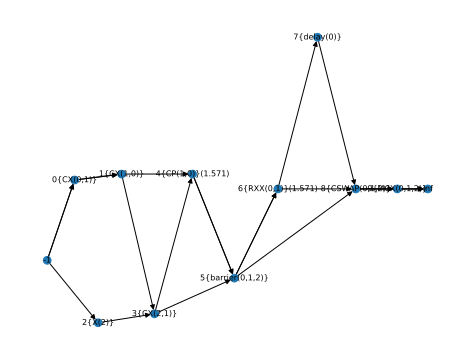

In [50]:
g = build_program_dependency_graph(simple)
draw_dependency_graph(g)

## 2 DAG visualization

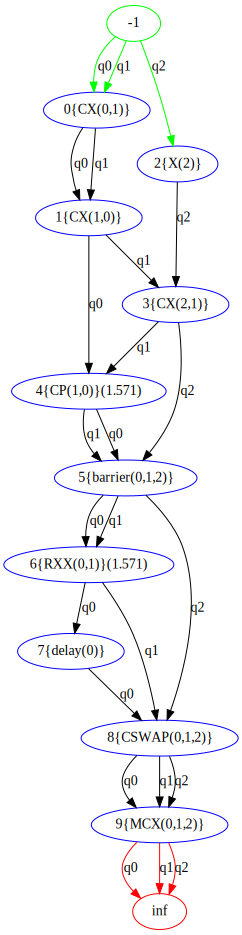

In [51]:
G = pgv.AGraph('file.dot')

G.layout(prog='dot') # use dot


# #png
# # 在这个ipynb中显示 foo.png 
# from IPython.display import Image
# G.draw('file.png')
# Image(filename='file.png')


# 在这个ipynb中显示 foo.svg
# svg
G.draw("foo.svg")
from IPython.display import SVG
SVG("foo.svg")

# 3. Transforming DAG to QuantumCircuit

In [52]:
dag_to_circ = dependency_graph_to_circuit(g, 3)

In [53]:
dag_to_circ.draw_circuit()

q[0]  --*----+---------P(1.571)----||-------#---------Delay(100ns)----*----*-- M->c[0]
        |    |            |        ||   RXX(1.571)                    |    |  
q[1]  --+----*----+-------*--------||-------#-------------------------x----*-- M->c[1]
                  |                ||                                 |    |  
q[2]  --X---------*----------------||---------------------------------x----X-- M->c[2]


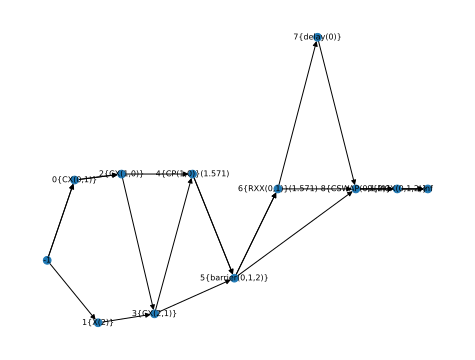

In [54]:
g_new = build_program_dependency_graph(dag_to_circ)
draw_dependency_graph(g_new)

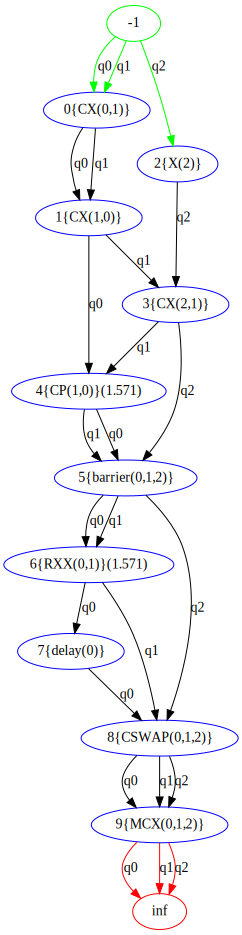

In [55]:
G_new = pgv.AGraph('file.dot')

G_new.layout(prog='dot') # use dot


# #png
# # 在这个ipynb中显示 foo.png 
# from IPython.display import Image
# G.draw('file_new.png')
# Image(filename='file_new.png')


# 在这个ipynb中显示 foo.svg
# svg
G.draw("foo_new.svg")
from IPython.display import SVG
SVG("foo_new.svg")